In [1]:
import arch_4 as arch # This is the model architecture to use
SEED = arch.SEED # Use same random seed for consistency
import utils

import os
import h5py
import numpy as np
np.random.seed(SEED)
from tqdm import tqdm, tnrange, tqdm_notebook
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing

In [3]:
# Import the data from file
f = h5py.File("data.mat")
data, labels = np.array(f['data']), np.array(f['labels'])

f.close()

In [4]:
# Get rid of zero columns
colInds = np.sum(data, axis=0) != 0.0
data = data[:, colInds]

In [5]:
# Normalize
data = np.log1p(data)

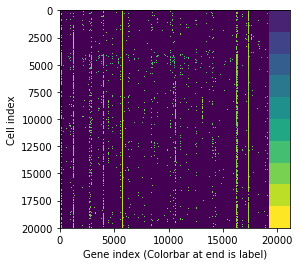

In [6]:
# Visualize data with labels
labels_scaled = labels * (data.max() - data.min()) / labels.max() - data.min()
plt.imshow(np.hstack((data, np.repeat(labels_scaled, data.shape[1] //  10, axis=1))))
plt.xlabel("Gene index (Colorbar at end is label)")
plt.ylabel("Cell index");

In [7]:
# Parameters to use for the rest of this workflow
BATCH_SIZE = 60
TEST_SIZE = 3000
NCLASS = 10

In [8]:
# Get test and training
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=TEST_SIZE, random_state=SEED)

In [9]:
# Subsample
train_data, train_labels = train_data[:600], train_labels[:600]
test_data, test_labels = test_data[:600], test_labels[:600]

In [10]:
## Maybe do some scaling?
#scaler = StandardScaler() # Fit on training set only.
#scaler.fit(train_data) # Apply transform to both the training set and the test set.
#train_data = scaler.transform(train_data)
#test_data = scaler.transform(test_data)

In [11]:
# Convert labels to one-hot format
train_labels = (np.arange(NCLASS) == train_labels).astype(np.float32)
test_labels = (np.arange(NCLASS) == test_labels).astype(np.float32)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


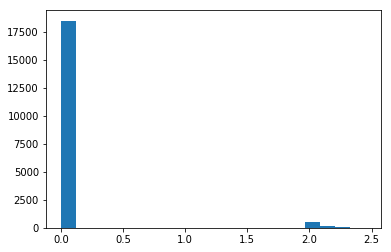

In [12]:
# Sanity check to make sure data is not crazy
plt.subplot(111).hist(train_data[0].flatten(), bins=20)
print(train_labels[0])

In [13]:
# Extract validation set from data
VAL_SIZE = int(train_data.shape[0] * 0.1)
val_data, train_data = train_data[:VAL_SIZE], train_data[VAL_SIZE:]
val_labels, train_labels = train_labels[:VAL_SIZE], train_labels[VAL_SIZE:]

In [14]:
train_data.shape

(540, 19232)

In [15]:
# Reshape data to the format specified by the particular architecture we are using
train_data = arch.reshape_data(train_data)
test_data = arch.reshape_data(test_data)
val_data = arch.reshape_data(val_data)

In [16]:
train_data.shape

(540, 19232, 1, 1)

# Defining computation graph

### Variables and input / output nodes

In [17]:
arch.make_vars_on_cpu(NCLASS)
train_data_node = tf.placeholder(tf.float32, [BATCH_SIZE] + list(train_data.shape[1:]))
train_label_node = tf.placeholder(tf.float32, [BATCH_SIZE, NCLASS])         
test_data_node, test_label_node = tf.constant(test_data, dtype=tf.float32), tf.constant(test_labels, dtype=tf.float32)
val_data_node, val_label_node = tf.constant(val_data, dtype=tf.float32), tf.constant(val_labels, dtype=tf.float32)

Instructions for updating:
Colocations handled automatically by placer.


### Losses, learning rate, and optimization step

In [18]:
val_out = arch.model(val_data_node)
val_probs = tf.nn.softmax(val_out)

test_out = arch.model(test_data_node)
test_probs = tf.nn.softmax(test_out)

logits, regularizers = arch.model(train_data_node, train=True)
probs = tf.nn.softmax(logits)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_label_node))
loss += regularizers

global_step = tf.Variable(0, trainable=False)
start_eta = 0.01
learning_rate = tf.train.exponential_decay(start_eta, global_step * BATCH_SIZE, train_labels.shape[0], 0.95, staircase=True)
update_weights = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.8).minimize(loss, global_step=global_step)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Training

In [19]:
sess = tf.InteractiveSession()
sess.as_default()
tf.global_variables_initializer().run()

### Sanity check, ensure that things are working

Initial mini-batch err: 88.33333333333333


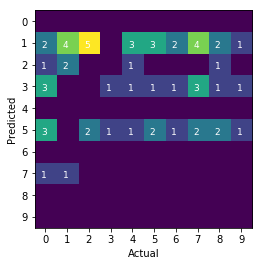

In [20]:
dat, lab = train_data[:BATCH_SIZE], train_labels[:BATCH_SIZE]

feed_dict = {train_data_node:dat, train_label_node:lab }
predictions, l = sess.run([probs, loss], feed_dict)

err, confusions = utils.error_rate(predictions, lab), utils.confusions(predictions, lab)
print(f"Initial mini-batch err: {err}")
utils.plot_confusions(confusions);

### Actual training

In [23]:
# Train over the first 1/4th of our training set.
n_epoch = 20
steps = (train_labels.shape[0] // BATCH_SIZE) * n_epoch
ls = np.empty(steps)
errs = np.empty(steps)
big_compute = 10
val_errs = np.empty(np.ceil(steps / big_compute).astype(int))

for step in tnrange(steps):
    # Compute the offset of the current minibatch in the data.
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE) # Should really randomize some
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {train_data_node: batch_data,
                 train_label_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, predictions = sess.run(
      [update_weights, loss, probs],
      feed_dict=feed_dict)
    ls[step] = l
    errs[step] = utils.error_rate(predictions, batch_labels)
    
    if step % big_compute == 0:
        val_errs[step // big_compute] = utils.error_rate(val_out.eval(), val_labels)
        print('Step %d of %d' % (step, steps))
        print("Mini-batch loss: {}, error: {}, val error: {}".format(ls[step], errs[step], val_errs[step // big_compute]))

Step 0 of 180
Mini-batch loss: 5.167716979980469, error: 91.66666666666666, val error: 95.0
Step 10 of 180
Mini-batch loss: 5.235576152801514, error: 90.0, val error: 95.0
Step 20 of 180
Mini-batch loss: 5.402993202209473, error: 83.33333333333334, val error: 95.0
Step 30 of 180
Mini-batch loss: 5.235146999359131, error: 93.33333333333333, val error: 95.0
Step 40 of 180
Mini-batch loss: 5.154592037200928, error: 85.0, val error: 95.0
Step 50 of 180
Mini-batch loss: 5.292929649353027, error: 96.66666666666667, val error: 95.0
Step 60 of 180
Mini-batch loss: 5.352622032165527, error: 88.33333333333333, val error: 95.0
Step 70 of 180
Mini-batch loss: 5.203484535217285, error: 90.0, val error: 95.0
Step 80 of 180
Mini-batch loss: 5.273540496826172, error: 96.66666666666667, val error: 95.0
Step 90 of 180
Mini-batch loss: 5.256792068481445, error: 85.0, val error: 95.0
Step 100 of 180
Mini-batch loss: 5.267982482910156, error: 88.33333333333333, val error: 95.0
Step 110 of 180
Mini-batch lo

# Evaluation

### Performance on test set

In [24]:
np.nonzero(np.sum(data, axis=0))[0].shape

(19232,)

In [25]:
with tf.compat.v1.variable_scope("arch_4", reuse=True):
    conv_w1 = tf.compat.v1.get_variable("fc1_b")
conv_w1.eval()

array([0.09786761, 0.0787015 , 0.11206543, 0.10643248, 0.07950993,
       0.09017812, 0.07547877, 0.09828056, 0.06878584, 0.09552026,
       0.08909034, 0.07208169, 0.09803157, 0.14339827, 0.10343558,
       0.11018957, 0.10347021, 0.0817204 , 0.11042266, 0.10464057,
       0.11465823, 0.08319425, 0.09276707, 0.10022287, 0.08878502,
       0.09915375, 0.1270005 , 0.07810514, 0.09391591, 0.10756237,
       0.09057524, 0.10034668, 0.08904797, 0.1093352 , 0.09038431,
       0.09612639, 0.09129227, 0.09468789, 0.10415152, 0.07380107,
       0.07074554, 0.102719  , 0.09477496, 0.12598109, 0.09461672,
       0.10163529, 0.09927732, 0.11244294, 0.10026262, 0.10323214,
       0.08007536, 0.08748016, 0.10806621, 0.1033666 , 0.08416717,
       0.10010932, 0.08847363, 0.06809842, 0.09509902, 0.06762474,
       0.0988286 , 0.11199239, 0.0809077 , 0.09632008, 0.06027835,
       0.1224689 , 0.09703808, 0.11102919, 0.07831938, 0.07611526,
       0.08886359, 0.0688433 , 0.0975439 , 0.11207443, 0.07998

Test error: 90.5


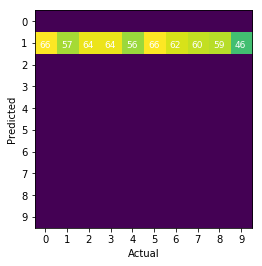

In [26]:
predicted, actual = test_probs.eval(), test_label_node.eval()
error = utils.error_rate(predicted, actual)
confusions = utils.confusions(predicted, actual)
print(f"Test error: {error}")
utils.plot_confusions(confusions);

In [ ]:
all([np.all(predicted[:, i] == predicted[0, i]) for i in range(10)])

### Learning curves

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(ls)
ax[0].set_xlabel("Training Step")
ax[0].set_ylabel("Loss (cross-entropy)")

ax[1].plot(errs, label="Training Error")
ax[1].scatter(np.arange(val_errs.shape[0]) * big_compute, val_errs, label="Validation Error", c='k')
ax[1].set_xlabel("Training Step")
ax[1].set_ylabel("Error rate (\%)")
ax[1].legend();

In [ ]:
dat, lab = train_data[:BATCH_SIZE], train_labels[:BATCH_SIZE]

feed_dict = {train_data_node:dat, train_label_node:lab }
predictions, l = sess.run([probs, loss], feed_dict)

err, confusions = utils.error_rate(predictions, lab), utils.confusions(predictions, lab)
print(f"Initial mini-batch err: {err}")
utils.plot_confusions(confusions);

### Failed stuff

In [ ]:
t_dat = test_data.reshape(test_data.shape[:2])
tr_dat = train_data.reshape(train_data.shape[:2])
v_dat = val_data.reshape(val_data.shape[:2])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(tr_dat)
ax[1].imshow(t_dat)
ax[2].imshow(v_dat)

In [ ]:
def checkIfSame(arr):
    return all([np.all(arr[:, i] == arr[0, i]) for i in range(arr.shape[1])])

In [ ]:
plt.imshow(test_data)

### Failed stuff

In [ ]:
# Do PCA
pca = PCA(200)
train_data = pca.fit_transform(train_data_s)
test_data = pca.transform(test_data_s)
data = pca.transform(data_0)

In [ ]:
from scipy.stats import linregress
cumvars = np.cumsum(pca.explained_variance_ratio_)
i = 20
res = linregress(np.arange(i, 200), cumvars[i:])
m, b = res.slope, res.intercept
plt.plot(cumvars)
plt.plot(np.arange(200), m * np.arange(200) + b)
(100 - b) / m